# VISCNN API DEMO

Before we begin, specify if you're using a machine with gpu's or not;

In [3]:
device = 'cuda:0'
#device = 'cpu'

## Model "Dissection"
 
VISCNN is a tool concerned with intermediary processing steps implemented by CNNs. One important intermediary that is often hidden in deep learning library's is the activation maps output by individual 2D kernels. Under normal circumstances, a convolutional layer has 'input' channels and 'output' channels. in pytorch, such a layer looks something like this;

In [2]:
import torch
from torch import nn


conv_layer = torch.nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3)
conv_layer

Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1))


We can pass 3 input maps (here our input 'maps' will be 6x6 arrays) into 'conv_layer' and it will produce 5 output maps;


In [3]:
input_maps = torch.rand(1,3,6,6) # we use '1' as our first dimension, 
                                   # as normally pytorch assumes we are operating on some 'batch' of multiple images
output_maps = conv_layer(input_maps)
output_maps.shape

torch.Size([1, 5, 4, 4])

These input and output maps don't show us the whole story, there are intermediary activation maps produced inside 
these conv layers. These hidden maps are produced by apply a single convolution kernel, before getting added together pointwise to generate an output channel activation map. With VISCNN, we can 'dissect' convolutional layers to get access to the full computational process;

In [4]:
from viscnn.dissected_Conv2d import dissected_Conv2d


dissected_conv_layer = dissected_Conv2d(conv_layer)
dissected_conv_layer

NameError: name 'conv_layer' is not defined


Dissected Conv modules perform the same operations as the original conv;


In [5]:
output_maps_2 = dissected_conv_layer(input_maps)

torch.isclose(output_maps_2,output_maps) #output_maps is what was outputted by the original conv_layer

tensor([[[[ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True]],

         [[ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True]],

         [[ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True, False,  True,  True]],

         [[ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True]],

         [[ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True],
          [ True,  True,  True,  True]]]])

We can set up our dissected conv to store intermediary values within the module

In [6]:
dissected_conv_layer = dissected_Conv2d(conv_layer,store_activations=True)
output_maps_2 = dissected_conv_layer(input_maps)

print('pre pointwise added activation maps')
print(dissected_conv_layer.preadd_out.shape) #all output activation maps, before point-wise summing into output channels
print('\n')

print('pre pointwise added activation maps sorted by out channels')
print(dissected_conv_layer.format_edges().shape) ##fetch preadd activations as [img,out_channel, in_channel,h,w]
print('\n')

print('final output activation maps')
print(dissected_conv_layer.postbias_out.shape) #normal activation maps outputted by conv_2d after summing and adding bias
print('\n')


pre pointwise added activation maps
torch.Size([1, 15, 4, 4])


pre pointwise added activation maps sorted by out channels
(1, 5, 3, 4, 4)


final output activation maps
torch.Size([1, 5, 4, 4])




We can also 'dissect' any entire convolutional neural network, iterating through its modules and separating each instance of 'Conv2d' with 'dissected_Conv2d';

In [5]:
from torchvision.models import alexnet
from viscnn.dissected_Conv2d import dissect_model
from copy import deepcopy  #well dissect the model on a copy of the original model, 
                           #as or dissector function dissects the model in place

    
model = alexnet(pretrained=True)
_ = model.to(device).eval()

dissected_model = dissect_model(deepcopy(model), store_activations = False, store_ranks = False, device=device)

print('original model modules:')
print(model)

print('dissected model modules:')
print(dissected_model)

original model modules:
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_fea

## feature visualization (with lucent)

For feature visualizations VISCNN uses the Lucent library, so we'll just demo their API here. For a more thorough demonstration of the power of lucent, check out the demos on their github (https://github.com/greentfrapp/lucent)

First we get a naming scheme, according to lucent, that we can use to reference the layers we want to visualize

In [8]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers

get_model_layers(model)


['features',
 'features_0',
 'features_1',
 'features_2',
 'features_3',
 'features_4',
 'features_5',
 'features_6',
 'features_7',
 'features_8',
 'features_9',
 'features_10',
 'features_11',
 'features_12',
 'avgpool',
 'classifier',
 'classifier_0',
 'classifier_1',
 'classifier_2',
 'classifier_3',
 'classifier_4',
 'classifier_5',
 'classifier_6']

We can visualize quickly by just referencing a model, the layer name, and a numerical index of the feature

layer 0, 10th feature


100%|██████████| 512/512 [00:05<00:00, 100.33it/s]



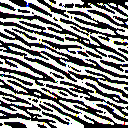

  2%|▏         | 11/512 [00:00<00:04, 102.38it/s]


 layer 8, 146th feature


100%|██████████| 512/512 [00:06<00:00, 84.15it/s]



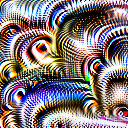

  2%|▏         | 8/512 [00:00<00:07, 71.94it/s]


 classification layer, 7th category (rooster)


100%|██████████| 512/512 [00:06<00:00, 75.87it/s]



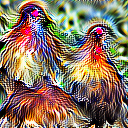

In [9]:
print('layer 0, 10th feature')
_ = render.render_vis(model, "features_0:10", show_inline=True)

print('\n layer 8, 146th feature')
_ = render.render_vis(model, "features_8:146", show_inline=True)

print('\n classification layer, 7th category (rooster)')
_ = render.render_vis(model, "classifier_6:7", show_inline=True)

We can visualizer our dissected model too, it produces the same feature visualizations (This will take longer, all operations on dissected_convs take more time and memory )

In [ ]:
get_model_layers(dissected_model)

## Delete


In [13]:
from viscnn.model_prep import utils

In [15]:
params = utils.load_prepped_model_params('alexnet_sparse')

In [18]:
params['layer_nodes'][4][1][199]

1095

  0%|          | 2/512 [00:00<00:28, 18.16it/s]

neuron-wise visualization


100%|██████████| 512/512 [00:24<00:00, 21.24it/s]



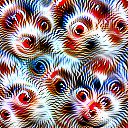

100%|██████████| 512/512 [00:24<00:00, 21.28it/s]



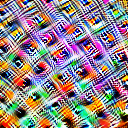

100%|██████████| 512/512 [00:24<00:00, 21.15it/s]



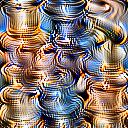

100%|██████████| 512/512 [00:24<00:00, 20.76it/s]



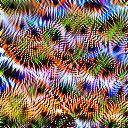

100%|██████████| 512/512 [00:24<00:00, 20.85it/s]



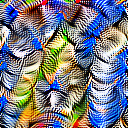

100%|██████████| 512/512 [00:24<00:00, 21.05it/s]



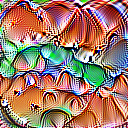

100%|██████████| 512/512 [00:24<00:00, 20.86it/s]



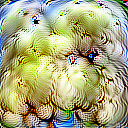

100%|██████████| 512/512 [00:24<00:00, 20.72it/s]



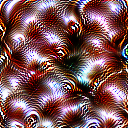

100%|██████████| 512/512 [00:24<00:00, 20.64it/s]



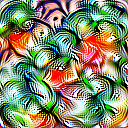

100%|██████████| 512/512 [00:24<00:00, 20.50it/s]



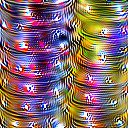

In [6]:
from lucent.optvis import render, param, transform, objectives
from lucent.modelzoo.util import get_model_layers

from lucent.modelzoo import alexnet

#model = alexnet(pretrained=True)
#_ = model.to('cuda').eval()

print('neuron-wise visualization')

for i in range(10):
    obj  = objectives.channel('features_10',i)
    _ = render.render_vis(dissected_model,  obj, show_inline=True)

## stop delete

In [ ]:
print('\n layer 8, 146th feature')
_ = render.render_vis(dissected_model, "features_8:146", show_inline=True)

Above we defaulted to a 'channel-wise' objective, which means 'generate an image that makes the sum over an entire feature-map high'. We could also use a 'neuron-wise' objective, which means 'generate an image which makes the central activation in the feature map high'. Neuron level visualizations often remove ambiguity in the channelwise visualization. For example, is feature_0:10 looking for black above white or white above black, or something else? 

(Note: one weird quirk with lucent visualizations: channel-wise visualizations often fail to optimize on dissected models, and neuron-wise visualizations often fail on undissected models. Not sure why.)

In [ ]:
print('layer 0, 10th feature \n')

obj  = objectives.channel('features_0',10)
print('channel-wise visualization')
_ = render.render_vis(model, obj, show_inline=True)

print('neuron-wise visualization')
obj  = objectives.neuron('features_0',10)
_ = render.render_vis(dissected_model, obj, show_inline=True)

we can also get any linear combinations of features visualized using Lucent pretty easily. We can also fetch visualizations in parallel to make everything faster.

In [ ]:
param_f = lambda: param.image(224, batch=3)   #set whats generated to 3 224x224 images


obj1 = objectives.channel("features_6",5, batch=0)  #batch 0 image set to visualize feature 5
obj2 = objectives.channel("features_6",6, batch=1)  #batch 1 image set to visualize feature 6
obj3 = objectives.channel("features_6",5, batch=2) + objectives.channel("features_6",6, batch=2)
#batch 2 image set to optimize a linear combination of both feature 5 and 6

obj = obj1+obj2+obj3


print('feature_6:5                 feature_6:5                feature_6:5+6')
_ = render.render_vis(model, obj, param_f, show_inline=True)

## Exploratory Visualizer

We can launch the visualizer tool from inside this notebook. It takes up a lot of memory, so'll we'll reset the notebook first, clearing all variables.

In [3]:
#%reset

from viscnn.visualizers.cnn_gui import launch_cnn_gui
launch_cnn_gui('alexnet_sparse',device='cuda:0',port=8052)

loading nodes rank data


/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/viscnn/ranks.py:215: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



loading node position data
loading convolutional kernels
loading edge data


set key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpm3l6e9d8.__wz_cache'


loading activation maps
building graph from browser "state"
Dash is running on http://0.0.0.0:8052/

Dash is running on http://0.0.0.0:8052/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://140.247.95.159:8052/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Oct/2021 16:10:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:10:24] "GET /assets/custom_divs.css?m=1632340318.7164469 HTTP/1.1" 304 -
127.0.0.1 - - [15/Oct/2021 16:10:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:10:27] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:10:32] "POST /_dash-update-component HTTP/1.1" 200 -


"" in ablation list is not a node/edge
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/l

127.0.0.1 - - [15/Oct/2021 16:10:32] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: extract_subgraph_call

Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/pytho

127.0.0.1 - - [15/Oct/2021 16:10:33] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be8

update ranksdf_store triggered
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
Updating cached rank dfs with overall


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'v7UzcsdPyqwxcvlWxS7txE' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpv3n72q03.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:10:34] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.217977   
1              1   features_0      0            0           1  1.793965   
2              2   features_0      0            0           2  0.604349   
3              3   features_0      0            1           0  0.479389   
4              4   features_0      0            1           1  1.453592   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.089054   
250044    250044  features_10      4          255         252  0.062168   
250045    250045  features_10      4          255         253  0.000005   
250046    250046  features_10      4          255         254  0.053664   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000014   2.927448e-05  
1        

get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9fnaieZo' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpj120s6q6.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:10:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:11:29] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_node_actmap_click


127.0.0.1 - - [15/Oct/2021 16:11:30] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: switch_edge_actmaps_click


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
get

CALLED: update_node_actmap
CALLED: update_edge_inmap
CALLED: update_edge_outmap
CALLED: update_node_deepviz
generating feature_viz objective string for 0
generating feature_viz objective string for 0
CALLED: update_edge_kernelmapCALLED: update_edge_deepviz
generating feature_viz objective string for g
generating feature_viz objective string for g

found pre-generated image
deepviz image not found for g, generating . . .
generating featviz with objective: <lucent.optvis.objectives.Objective object at 0x7fc91d6cc390>
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpax7_2uui.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:11:52] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_store

TRIGGER node-actmap-dropdown.value
g-21
CALLED: update_node_inputs
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


  0%|          | 0/512 [00:00<?, ?it/s]

CALLED: update_figure

[0.7, 1]
['g-21']
['0']
updating edge highlight to g-21
updating node highlight to 0
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, out


127.0.0.1 - - [15/Oct/2021 16:11:52] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:11:52] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpz5eoxn40.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with s
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/

127.0.0.1 - - [15/Oct/2021 16:12:05] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpxjqzqksp.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with sm
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris

127.0.0.1 - - [15/Oct/2021 16:12:05] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpwhd2tcri.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with sma
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chri

127.0.0.1 - - [15/Oct/2021 16:12:06] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp7ao3jgfn.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with smal
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chr

127.0.0.1 - - [15/Oct/2021 16:12:06] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp3jc6nmda.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with small
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/ch

127.0.0.1 - - [15/Oct/2021 16:12:06] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmphofk2tls.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with small_
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/c

127.0.0.1 - - [15/Oct/2021 16:12:06] "POST /_dash-update-component HTTP/1.1" 500 -


update ranksdf_store triggered

get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpt88a5v2z.__wz_cache'



Updating cached rank dfs with small_S
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/l

127.0.0.1 - - [15/Oct/2021 16:12:07] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc

update ranksdf_store triggered
update ranksdf_store triggered
Updating cached rank dfs with small_SP
Updating cached rank dfs with small_SPA
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    

127.0.0.1 - - [15/Oct/2021 16:12:07] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py

127.0.0.1 - - [15/Oct/2021 16:12:07] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpo4dl5tez.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNe3cypU' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpd_uhtvlp.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:12:08] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmptkvep521.__wz_cache'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cac

CALLED: update_node_inputs
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
CALLED: update_store

TRIGGER target-signal.children
Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNNc1RIQ' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpqmnapfs2.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/viscnn/ranks.py:215: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

127.0.0.1 - - [15/Oct/2021 16:12:10] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:12:10] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0']
building graph from browser "state"


127.0.0.1 - - [15/Oct/2021 16:12:21] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:12:21] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpbrpwsd_b.__wz_cache'


CALLED: switch_edge_actmaps_click
CALLED: switch_node_actmap_click
CALLED: update_edge_inmap
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9fmsni/x' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp9q07sa4i.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:12:38] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch

CALLED: update_edge_outmap
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


127.0.0.1 - - [15/Oct/2021 16:12:38] "POST /_dash-update-component HTTP/1.1" 200 -
  0%|          | 0/512 [00:00<?, ?it/s]

CALLED: update_edge_deepviz
generating feature_viz objective string for g
generating feature_viz objective string for g
deepviz image not found for g, generating . . .
generating featviz with objective: <lucent.optvis.objectives.Objective object at 0x7fc940376f10>
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.


127.0.0.1 - - [15/Oct/2021 16:12:39] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/Oct/2021 16:12:39] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'


CALLED: update_edge_kernelmap
CALLED: update_node_actmap


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpxrmesyyr.__wz_cache'


Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9fNuc3Sm' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpbp6y8vn7.__wz_cache'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9f8MXxmt' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpjrbdn59q.__wz_cache'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualize

Updating cached rank dfs with overall
CALLED: update_store



127.0.0.1 - - [15/Oct/2021 16:12:40] "POST /_dash-update-component HTTP/1.1" 200 -


TRIGGER edge-actmaps-input.value
g-21
changing selected node to 75
CALLED: update_node_deepviz
generating feature_viz objective string for 75
generating feature_viz objective string for 75
found pre-generated image


127.0.0.1 - - [15/Oct/2021 16:12:40] "POST /_dash-update-component HTTP/1.1" 200 -
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'v7UzcsdPyqwxcvlW0iOSSK' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpci65chyl.__wz_cache'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch

FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.217977   
1              1   features_0      0            0           1  1.793965   
2              2   features_0      0            0           2  0.604349   
3              3   features_0      0            1           0  0.479389   
4              4   features_0      0            1           1  1.453592   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.089054   
250044    250044  features_10      4          255         252  0.062168   
250045    250045  features_10      4          255         253  0.000005   
250046    250046  features_10      4          255         254  0.053664   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000014   2.927448e-05  
1        

127.0.0.1 - - [15/Oct/2021 16:12:41] "POST /_dash-update-component HTTP/1.1" 200 -


generating feature_viz objective string for g-0
generating feature_viz objective string for g-0
found pre-generated edge image
generating feature_viz objective string for r-0
generating feature_viz objective string for r-0
found pre-generated edge image
generating feature_viz objective string for b-0
generating feature_viz objective string for b-0
found pre-generated edge image


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpah62wvyw.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079

127.0.0.1 - - [15/Oct/2021 16:12:41] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py

127.0.0.1 - - [15/Oct/2021 16:12:41] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py

127.0.0.1 - - [15/Oct/2021 16:12:41] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/Oct/2021 16:12:42] "POST /_dash-update-component HTTP/1.1" 200 -


target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
updating edge highlight to g-21
updating node highlight to 75
0 0 features_0
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-package

127.0.0.1 - - [15/Oct/2021 16:12:42] "POST /_dash-update-component HTTP/1.1" 500 -


Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py

127.0.0.1 - - [15/Oct/2021 16:12:42] "POST /_dash-update-component HTTP/1.1" 500 -


CALLED: update_inputimg_actmap
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/pytho

127.0.0.1 - - [15/Oct/2021 16:12:49] "POST /_dash-update-component HTTP/1.1" 500 -
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9fDDq3tF' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp_4mgqx_u.__wz_cache'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn

Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNJBpgoi' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpzh_9c11p.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

127.0.0.1 - - [15/Oct/2021 16:12:52] "POST /_dash-update-component HTTP/1.1" 200 -
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9fU0gHIc' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpcuso7pr5.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:12:55] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cac

update ranksdf_store triggered
Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNwip4nK' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmposxcozjy.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:12:56] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp2rla_e7z.__wz_cache'


CALLED: update_node_inputs
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations


127.0.0.1 - - [15/Oct/2021 16:12:57] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpzwmkjpla.__wz_cache'


CALLED: update_store

TRIGGER target-signal.children
Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNyGeEDD' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpwha9c8vg.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/viscnn/ranks.py:215: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

127.0.0.1 - - [15/Oct/2021 16:12:59] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:12:59] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62Vk6Dsl' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp0d9i0e90.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:13:03] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'IjCeFY1SsnhftG9f1wR9xs' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp0ujk_xtn.__wz_cache'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chr

Updating cached rank dfs with small_SPAN


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key '9hkrD/IJ2VVeYDHNPOuj3l' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp96gcnbzl.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.107067   
250044    250044  features_10      4          255         252  0.061349   
250045    250045  features_10      4          255         253  0.000004   
250046    250046  features_10      4          255         254  0.051553   
250047    250047  features_10      4          255         255  0.000042   

        grad_rank  actxgrad_rank  
0        0.000012   2.696508e-05  
1        

127.0.0.1 - - [15/Oct/2021 16:13:09] "POST /_dash-update-component HTTP/1.1" 200 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpul_4ajl3.__wz_cache'


update ranksdf_store triggered
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62m5yyrk' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmprzgikwgt.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:13:27] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpkpspswmd.__wz_cache'
get key '__wz_cac

CALLED: update_store
CALLED: update_node_inputs

TRIGGER target-signal.children
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_function

127.0.0.1 - - [15/Oct/2021 16:13:29] "POST /_dash-update-component HTTP/1.1" 500 -


batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62pWFLmE' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpduxhzyye.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.315682   
1              1   features_0      0            0           1  1.935367   
2              2   features_0      0            0           2  0.618764   
3              3   features_0      0            1           0  0.499245   
4              4   features_0      0            1           1  1.524424   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:13:35] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:13:35] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp7b9ionw7.__wz_cache'


CALLED: update_store

TRIGGER edge-thresh-slider.value
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62Mbk41Q' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpqpe_9khs.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:14:16] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000004  
1        

127.0.0.1 - - [15/Oct/2021 16:14:16] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpunrgud8p.__wz_cache'


CALLED: update_store

TRIGGER edge-thresh-slider.value
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62FyIYXB' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp1by9i85m.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:14:26] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:14:26] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpweye04fd.__wz_cache'


CALLED: update_store

TRIGGER node-thresh-slider.value
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62KqFK4q' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp2orcg83_.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:14:37] "POST /_dash-update-component HTTP/1.1" 500 -
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.activations_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/eb23f7fc4f75ee380dc9ff1138de6769'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be8

CALLED: update_node_inputsCALLED: update_store

TRIGGER subgraph-criterion.value

Updating cached rank dfs with small_SPAN
Updating cached activations with Afghan_hound_10.JPEG
running model to fetch activations
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functi

127.0.0.1 - - [15/Oct/2021 16:14:59] "POST /_dash-update-component HTTP/1.1" 500 -


batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j620j9V0V' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmp2e3q6hdt.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.315682   
1              1   features_0      0            0           1  1.935367   
2              2   features_0      0            0           2  0.618764   
3              3   features_0      0            1           0  0.499245   
4              4   features_0      0            1           1  1.524424   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:15:04] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:15:05] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpzzqx0clc.__wz_cache'


CALLED: update_store

TRIGGER node-thresh-slider.value
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62saS53V' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpm7_e5bex.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:15:40] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:15:40] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpwz04b4i1.__wz_cache'


CALLED: update_store

TRIGGER edge-thresh-slider.value
Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j625FA5Ka' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpl3snm4_p.__wz_cache'
127.0.0.1 - - [15/Oct/2021 16:16:00] "POST /_dash-update-component HTTP/1.1" 200 -


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:16:00] "POST /_dash-update-component HTTP/1.1" 200 -


CALLED: update_figure

[0.7, 1]
['g-21']
['0', '75']
building graph from browser "state"


get key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/7a2d3c69ab627088e593b8645c43e1fb'
get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'viscnn.visualizers.cnn_gui.launch_cnn_gui.<locals>.ranksdf_store_memver' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpp2x9xcmm.__wz_cache'


CALLED: extract_subgraph_call

Updating cached rank dfs with small_SPAN
running model to get ranks for "small_SPAN" on target "75"
using device cuda:0
batch 0
target node 75 reached, halted forward pass
batch 1
target node 75 reached, halted forward pass
batch 2
target node 75 reached, halted forward pass
batch 3
target node 75 reached, halted forward pass
batch 4
target node 75 reached, halted forward pass
batch 5
target node 75 reached, halted forward pass
batch 6
target node 75 reached, halted forward pass
batch 7
target node 75 reached, halted forward pass


get key '__wz_cache_count' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/2029240f6d1128be89ddc32729463129'
set key 'noTZ/FFqZ8QK1j62Zilojq' -> [Errno 13] Permission denied: '/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse/cache/tmpme6g0kiq.__wz_cache'


FROM RANKS DF STORE
        edge_num   layer_name  layer  out_channel  in_channel  act_rank  \
0              0   features_0      0            0           0  1.312708   
1              1   features_0      0            0           1  1.933793   
2              2   features_0      0            0           2  0.614869   
3              3   features_0      0            1           0  0.494262   
4              4   features_0      0            1           1  1.509352   
...          ...          ...    ...          ...         ...       ...   
250043    250043  features_10      4          255         251  0.000000   
250044    250044  features_10      4          255         252  0.000000   
250045    250045  features_10      4          255         253  0.000000   
250046    250046  features_10      4          255         254  0.000000   
250047    250047  features_10      4          255         255  0.000000   

        grad_rank  actxgrad_rank  
0        0.000002       0.000005  
1        

127.0.0.1 - - [15/Oct/2021 16:16:41] "POST /_dash-update-component HTTP/1.1" 200 -


layer: 0
layer: 1
SHOULD HAVE SAVED


## Circuit Visualizer

Circuit visualizers shows the connections between kernels and features in one image, in the manner of Olah 2020 https://distill.pub/2020/circuits/zoom-in/

/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/torch/cuda/__init__.py:125: UserWarning:


Tesla K40c with CUDA capability sm_35 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 compute_37.
If you want to use the Tesla K40c GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/




/mnt/data/chris/dropbox/Research-Hamblin/Projects/cnn_subgraph_visualizer/prepped_models/alexnet_sparse
generating feature_viz objective string for 17
found pre-generated image
generating feature_viz objective string for 19
found pre-generated image
generating feature_viz objective string for 21
found pre-generated image
generating feature_viz objective string for 32
deepviz image not found for 32, generating . . .
generating featviz with objective: conv_0:32


100%|██████████| 512/512 [00:04<00:00, 112.58it/s]



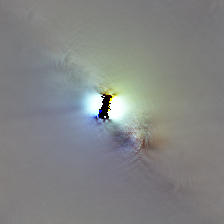

  2%|▏         | 10/512 [00:00<00:05, 91.52it/s]

generating feature_viz objective string for 35
deepviz image not found for 35, generating . . .
generating featviz with objective: conv_0:35


100%|██████████| 512/512 [00:04<00:00, 105.54it/s]



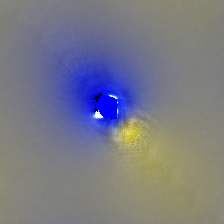

  2%|▏         | 9/512 [00:00<00:05, 86.37it/s]

generating feature_viz objective string for 36
deepviz image not found for 36, generating . . .
generating featviz with objective: conv_0:36


100%|██████████| 512/512 [00:04<00:00, 109.45it/s]



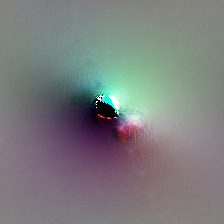

  2%|▏         | 10/512 [00:00<00:05, 92.78it/s]

generating feature_viz objective string for 37
deepviz image not found for 37, generating . . .
generating featviz with objective: conv_0:37


100%|██████████| 512/512 [00:04<00:00, 114.12it/s]



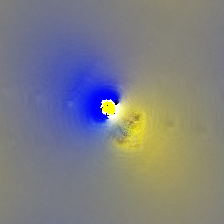

  2%|▏         | 10/512 [00:00<00:05, 94.06it/s]

generating feature_viz objective string for 38
deepviz image not found for 38, generating . . .
generating featviz with objective: conv_0:38


100%|██████████| 512/512 [00:04<00:00, 109.06it/s]



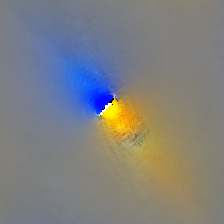

  2%|▏         | 10/512 [00:00<00:05, 92.08it/s]

generating feature_viz objective string for 40
deepviz image not found for 40, generating . . .
generating featviz with objective: conv_0:40


100%|██████████| 512/512 [00:04<00:00, 106.02it/s]



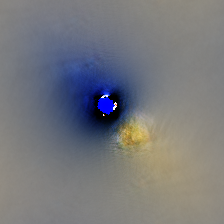

  3%|▎         | 13/512 [00:00<00:04, 120.30it/s]

generating feature_viz objective string for 42
deepviz image not found for 42, generating . . .
generating featviz with objective: conv_0:42


100%|██████████| 512/512 [00:04<00:00, 110.27it/s]



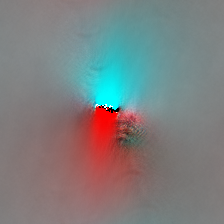

  2%|▏         | 10/512 [00:00<00:05, 92.93it/s]

generating feature_viz objective string for 46
deepviz image not found for 46, generating . . .
generating featviz with objective: conv_0:46


100%|██████████| 512/512 [00:04<00:00, 110.14it/s]



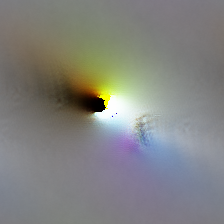

  2%|▏         | 12/512 [00:00<00:04, 114.67it/s]

generating feature_viz objective string for 52
deepviz image not found for 52, generating . . .
generating featviz with objective: conv_0:52


100%|██████████| 512/512 [00:04<00:00, 110.12it/s]



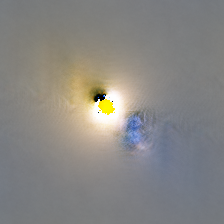

  2%|▏         | 12/512 [00:00<00:04, 117.51it/s]

generating feature_viz objective string for 75
deepviz image not found for 75, generating . . .
generating featviz with objective: conv_1:75


100%|██████████| 512/512 [00:04<00:00, 105.17it/s]



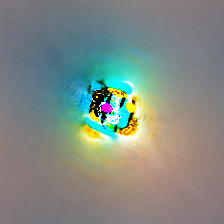

Dash is running on http://0.0.0.0:8052/

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on all addresses.
 * Running on http://140.247.95.159:8052/ (Press CTRL+C to quit)
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /assets/custom_divs.css?m=1632340318.7164469 HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /_dash-component-suites/dash_daq/dash_daq.v0_5_0m1596869724.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /_dash-component-suites/dash_renderer/polyfill@7.v1_9_1m1617985068.8.7.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /_dash-component-suites/dash_renderer/react-dom@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /_dash-component-suites/dash_renderer/prop-types@15.v1_9_1m1617985068.7.2.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:09] "GET /_dash-component-suites/dash_renderer/react@16.v1_9_1m1617985068.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [15/Oct/2021 16:19:10] "GET /_dash-component-suites/das

None
Exception on /_dash-update-component [POST]
Traceback (most recent call last):
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 2070, in wsgi_app
    response = self.full_dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1515, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1513, in full_dispatch_request
    rv = self.dispatch_request()
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/flask/app.py", line 1499, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**req.view_args)
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/dash.py", line 1079, in dispatch
    response.set_data(func(*args, outputs_list=outputs_list))
  File "/home/chris/miniconda3/envs/viscnn/lib/python3.7/site-packages/dash/da

127.0.0.1 - - [15/Oct/2021 16:19:18] "POST /_dash-update-component HTTP/1.1" 500 -
127.0.0.1 - - [15/Oct/2021 16:19:51] "POST /_dash-update-component HTTP/1.1" 200 -


None
feat_size.value


127.0.0.1 - - [15/Oct/2021 16:20:06] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 2, 'pointIndex': 2, 'x': 0, 'y': -3.5, 'text': '21', 'customdata': [21, 21, 1]}]}
fig.clickData


127.0.0.1 - - [15/Oct/2021 16:21:03] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 3, 'pointIndex': 3, 'x': 0, 'y': -2.5, 'text': '32', 'customdata': [32, 32, 0.24360231206175026]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [15/Oct/2021 16:21:25] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 8, 'pointIndex': 8, 'x': 0, 'y': 2.5, 'text': '40', 'customdata': [40, 40, 0.3964213904047533]}]}
fig.clickData


127.0.0.1 - - [15/Oct/2021 16:23:33] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 7, 'pointIndex': 7, 'x': 0, 'y': 1.5, 'text': '38', 'customdata': [38, 38, 0.22745763327386323]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [15/Oct/2021 16:23:40] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 15, 'pointNumber': 2, 'pointIndex': 2, 'x': -3, 'y': -1}]}
fig.clickData


127.0.0.1 - - [15/Oct/2021 16:23:48] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 5, 'pointIndex': 5, 'x': 0, 'y': -0.5, 'text': '36', 'customdata': [36, 36, 0.2243829673427652]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [15/Oct/2021 16:24:15] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 7, 'pointIndex': 7, 'x': 0, 'y': 1.5, 'text': '38', 'customdata': [38, 38, 0.22745763327386323]}]}
fig.clickData


127.0.0.1 - - [15/Oct/2021 16:25:14] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 5, 'pointIndex': 5, 'x': 0, 'y': -0.5, 'text': '36', 'customdata': [36, 36, 0.2243829673427652]}]}
fig.clickData
resetting graph opacity


127.0.0.1 - - [15/Oct/2021 16:25:29] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 1, 'pointIndex': 1, 'x': 0, 'y': -4.5, 'text': '19', 'customdata': [19, 19, 0.33109196504970345]}]}
fig.clickData


127.0.0.1 - - [15/Oct/2021 16:27:58] "POST /_dash-update-component HTTP/1.1" 200 -


{'points': [{'curveNumber': 1, 'pointNumber': 7, 'pointIndex': 7, 'x': 0, 'y': 1.5, 'text': '38', 'customdata': [38, 38, 0.22745763327386323]}]}
fig.clickData
resetting graph opacity


In [ ]:
#%reset

from viscnn.visualizers.circuit_gui import launch_circuit_gui
subgraph_dict_path = 'prepped_models/alexnet_sparse/subgraphs/models/test_of_75.pt'

launch_circuit_gui(subgraph_dict_path,port=8052,params=None,viz_folder=None)

## Subgraph extraction with API

We dont have to go through this messy GUI to extract subgraphs from our model, we can do it more efficiently programmatically 

In [ ]:
from torchvision.models import alexnet

m = alexnet()